# Semi-supervised learning in credit card fraud detection

In [1]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
sns.set()
np.random.seed(42)

### Exploratory analysis

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df['Time'] = df['Time'].apply(lambda x : x / 3600 % 24)

In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,1.453795e+01,5.847061,0.000000,10.598194,15.010833,19.329722,23.999444
V1,284807.0,3.919560e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,5.688174e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-8.769071e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.782312e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,-1.552563e-15,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,2.010663e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-1.694249e-15,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,-1.927028e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-3.137024e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

**Observations**: The data is highly imbalanced.

### Look at the separability of the target classes

In [7]:
df_non_fraud = df[df['Class'] == 0].sample(5000)
df_fraud = df[df['Class'] == 1]

df_temp = df_non_fraud.append(df_fraud).reset_index(drop = True)

In [8]:
X_feature = df_temp.drop(['Class'], axis = 1).values
y_target  = df_temp['Class'].values

In [9]:
def TSNE_plot(x, y):
    tsne = TSNE(n_components = 2, random_state =42)
    X_t = tsne.fit_transform(x)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y == 0), 0], X_t[np.where(y == 0), 1], marker='o', color='b', linewidth='1', alpha=0.4, label='Non Fraud')
    plt.scatter(X_t[np.where(y == 1), 0], X_t[np.where(y == 1), 1], marker='x', color='r', linewidth='1', alpha=1, label='Fraud')

    plt.legend(loc='best');
    plt.show();

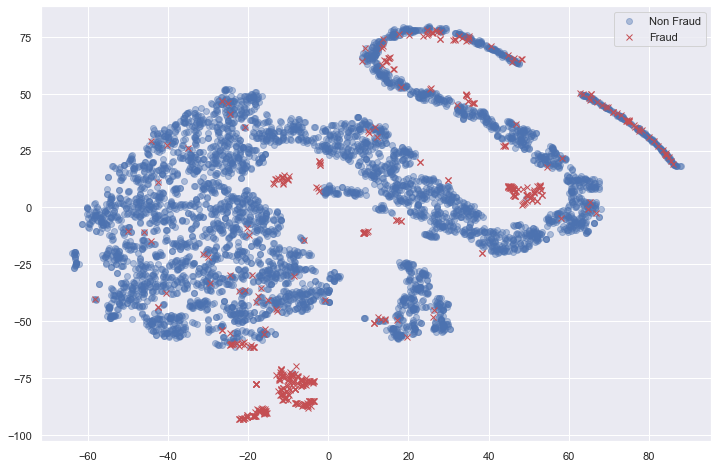

In [10]:
TSNE_plot(X_feature, y_target)

**Observations**: The target classes are not separable in this space.

### Feed sample into a SVM classifer

In [11]:
from sklearn.model_selection import train_test_split 
from sklearn import svm

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_feature, y_target, test_size=0.2, random_state = 42)
clf = svm.SVC(C=1.0, kernel ='rbf', gamma='auto').fit(X_train, y_train)

In [13]:
y_pred = clf.predict(X_test)

In [14]:
print ("")
print ("Classification Report: ")
print (classification_report(y_test, y_pred))

print ("")
print ("Accuracy Score: ", accuracy_score(y_test, y_pred))


Classification Report: 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       984
           1       0.96      0.42      0.58       115

   micro avg       0.94      0.94      0.94      1099
   macro avg       0.95      0.71      0.77      1099
weighted avg       0.94      0.94      0.93      1099


Accuracy Score:  0.9372156505914467


**Observation**: High accuracy score obscures the poor $F$-score on classifying fraudulent predictions. 

### Data preprocessing

In [15]:
# Train test split
train, test = train_test_split(df, test_size = 0.2, random_state = 42)
train = train.reset_index(drop = True)
test = test.reset_index(drop = True)

In [16]:
train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,15.820000,1.955041,-0.380783,-0.315013,0.330155,-0.509374,-0.086197,-0.627978,0.035994,1.054560,-0.030441,0.624996,1.691496,1.255790,-0.253266,-0.331695,0.307252,-0.930844,0.651666,0.167987,-0.125390,0.238197,0.968305,0.053208,-0.278602,-0.044999,-0.216780,0.045168,-0.047145,9.99,0
1,8.548056,-0.400975,-0.626943,1.555339,-2.017772,-0.107769,0.168310,0.017959,-0.401619,0.040378,0.611115,-1.945070,-0.726597,1.060888,-1.193347,0.631053,-0.160123,-1.630444,2.106866,-1.692780,-0.470372,-0.153485,0.421703,0.113442,-1.004095,-1.176695,0.361924,-0.370469,-0.144792,45.90,0
2,17.545833,0.072509,0.820566,-0.561351,-0.709897,1.080399,-0.359429,0.787858,0.117276,-0.131275,-0.638222,0.521931,-0.072768,-1.008237,-0.640249,-0.801946,0.678131,0.044374,0.521919,0.198772,0.012227,-0.314638,-0.872959,0.083391,0.148178,-0.431459,0.119690,0.206395,0.070288,11.99,0
3,2.019444,-0.535045,1.014587,1.750679,2.769390,0.500089,1.002270,0.847902,-0.081323,0.371579,0.560595,-0.855437,-4.179628,0.286872,1.271254,-1.011647,1.458600,-0.613260,0.814931,-2.147124,-0.253757,0.063525,0.443431,-0.072754,0.448192,-0.655203,-0.181038,-0.093013,-0.064931,117.44,0
4,22.959722,-4.026938,1.897371,-0.429786,-0.029571,-0.855751,-0.480406,-0.435632,1.313760,0.536044,1.221746,0.472626,1.595929,0.777603,0.187685,-1.060579,0.143332,0.007803,-0.055817,0.712695,-0.012320,-0.480691,-0.230369,0.250717,0.066399,0.470787,0.245335,0.286904,-0.322672,25.76,0


Normalize only the 'Time' and 'Amount' variable since all other variables are extracted from PCA. 

In [17]:
# Training set
train['Time'] = preprocessing.StandardScaler().fit_transform(train['Time'].values.reshape(-1, 1))
train['Amount'] = preprocessing.StandardScaler().fit_transform(train['Amount'].values.reshape(-1, 1))
                                                              
# Testing set                   
test['Time'] = preprocessing.StandardScaler().fit_transform(test['Time'].values.reshape(-1, 1))
test['Amount'] = preprocessing.StandardScaler().fit_transform(test['Amount'].values.reshape(-1, 1))

In [18]:
train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.220586,1.955041,-0.380783,-0.315013,0.330155,-0.509374,-0.086197,-0.627978,0.035994,1.054560,-0.030441,0.624996,1.691496,1.255790,-0.253266,-0.331695,0.307252,-0.930844,0.651666,0.167987,-0.125390,0.238197,0.968305,0.053208,-0.278602,-0.044999,-0.216780,0.045168,-0.047145,-0.307889,0
1,-1.023177,-0.400975,-0.626943,1.555339,-2.017772,-0.107769,0.168310,0.017959,-0.401619,0.040378,0.611115,-1.945070,-0.726597,1.060888,-1.193347,0.631053,-0.160123,-1.630444,2.106866,-1.692780,-0.470372,-0.153485,0.421703,0.113442,-1.004095,-1.176695,0.361924,-0.370469,-0.144792,-0.167026,0
2,0.515765,0.072509,0.820566,-0.561351,-0.709897,1.080399,-0.359429,0.787858,0.117276,-0.131275,-0.638222,0.521931,-0.072768,-1.008237,-0.640249,-0.801946,0.678131,0.044374,0.521919,0.198772,0.012227,-0.314638,-0.872959,0.083391,0.148178,-0.431459,0.119690,0.206395,0.070288,-0.300043,0
3,-2.139804,-0.535045,1.014587,1.750679,2.769390,0.500089,1.002270,0.847902,-0.081323,0.371579,0.560595,-0.855437,-4.179628,0.286872,1.271254,-1.011647,1.458600,-0.613260,0.814931,-2.147124,-0.253757,0.063525,0.443431,-0.072754,0.448192,-0.655203,-0.181038,-0.093013,-0.064931,0.113600,0
4,1.441734,-4.026938,1.897371,-0.429786,-0.029571,-0.855751,-0.480406,-0.435632,1.313760,0.536044,1.221746,0.472626,1.595929,0.777603,0.187685,-1.060579,0.143332,0.007803,-0.055817,0.712695,-0.012320,-0.480691,-0.230369,0.250717,0.066399,0.470787,0.245335,0.286904,-0.322672,-0.246029,0


In [19]:
train['Class'].value_counts()

0    227451
1       394
Name: Class, dtype: int64

In [20]:
# Train test split
#train, test = train_test_split(df_norm, test_size = 0.2, random_state = 42)

X_train_nonfraud = train[train['Class'] == 0]    #Non-fradualent data only
X_train_fraud    = train[train['Class'] == 1]    #Fradualent data only

X_test_nonfraud = test[test['Class'] == 0]    #Non-fradualent data only
X_test_fraud    = test[test['Class'] == 1]    #Fradualent data only

X_train_nonfraud = X_train_nonfraud.drop(['Class'], axis = 1) #Drop the class column
X_train_fraud    = X_train_fraud.drop(['Class'], axis = 1)    #Drop the class column

X_test_nonfraud = X_test_nonfraud.drop(['Class'], axis = 1) #Drop the class column
X_test_fraud    = X_test_fraud.drop(['Class'], axis = 1)    #Drop the class column


# Convert to np array
X_train_nonfraud = X_train_nonfraud.values  #For autoencoder training
X_train_fraud = X_train_fraud.values  #For autoencoder training
X_test_nonfraud = X_test_nonfraud.values  #For autoencoder training
X_test_fraud = X_test_fraud.values  #For autoencoder training


### Autoencoders

In [21]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers

Using TensorFlow backend.


In [22]:
# Hyperparameters 
n_feat           = X_train_nonfraud.shape[1]
enc1_units       = 25
code_units       = 20
dec1_units       = enc1_units
learning_rate    = 1e-4

In [23]:
def create_autoencoder():
    # Input
    input_layer  = Input(shape = (n_feat, ))
    # Encoding
    encoded      = Dense(enc1_units, activation = 'tanh', activity_regularizer=regularizers.l1(learning_rate))(input_layer)
    # Code (i.e., Bottleneck layer)
    code         = Dense(code_units, activation = 'relu')(encoded)
    # Decoding
    decoded      = Dense(dec1_units, activation = 'tanh')(code)
    # Output
    output_layer = Dense(n_feat, activation = 'relu')(decoded)
    
    return Model(inputs = input_layer, outputs = output_layer)
    

In [24]:
autoencoder = create_autoencoder()
autoencoder.compile(optimizer = 'adam', loss = 'mse')
autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                775       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                520       
_________________________________________________________________
dense_3 (Dense)              (None, 25)                525       
_________________________________________________________________
dense_4 (Dense)              (None, 30)                780       
Total params: 2,600
Trainable params: 2,600
Non-trainable params: 0
_________________________________________________________________


Train the autoencoder to only recognize non-fraudulent data. For demonstration purposes, only a 

In [25]:
history = autoencoder.fit(X_train_nonfraud[:3000], X_train_nonfraud[:3000], batch_size = 128, 
                     epochs =100, shuffle = True, validation_split = 0.2, verbose = 0).history

Instructions for updating:
Use tf.cast instead.


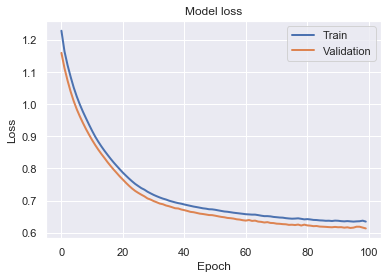

In [26]:
# Plot autoencoder training history
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Validation')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

**Observations**: No signs of severe overfitting. Could further improve model by experimenting the hidden layers units.

### Extract latent representations

Build off from autoencoder to extract the latent variables. This is the first 3 layers of the autoencoder model.

In [27]:
latent_rep = Sequential()
latent_rep.add(autoencoder.layers[0])
latent_rep.add(autoencoder.layers[1])
latent_rep.add(autoencoder.layers[2])

In [28]:
def latent_rep_extract(X_nonfraud, X_fraud, model, nf_size):
    nonfraud_latent_rep = model.predict(X_train_nonfraud[:nf_size])
    fraud_latent_rep    = model.predict(X_train_fraud)
    
    X_rep = np.append(nonfraud_latent_rep, fraud_latent_rep, axis = 0)
    
    # Label the latent variables
    y_n   = np.zeros(nonfraud_latent_rep.shape[0])
    y_f   = np.ones(fraud_latent_rep.shape[0])
    y_rep = np.append(y_n, y_f)
    
    return X_rep, y_rep

Produce the latent variables for the two classes using the above model.

In [29]:
X_rep_train, y_rep_train = latent_rep_extract(X_train_nonfraud, X_train_fraud, latent_rep, 4000)
X_rep_test, y_rep_test = latent_rep_extract(X_test_nonfraud, X_test_fraud, latent_rep, 1000)

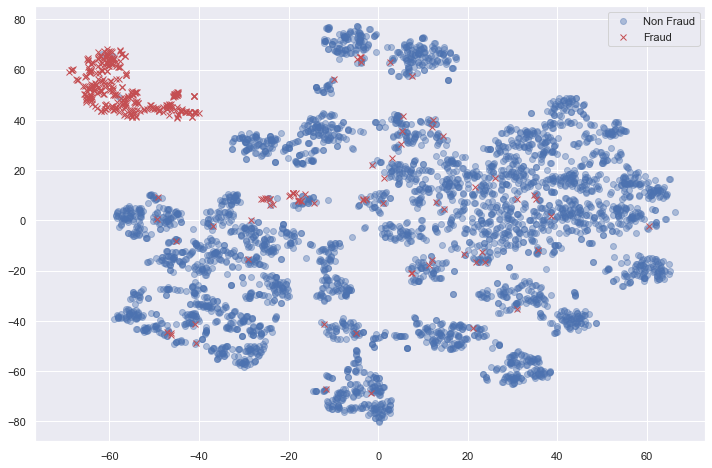

In [30]:
TSNE_plot(X_rep_train, y_rep_train)

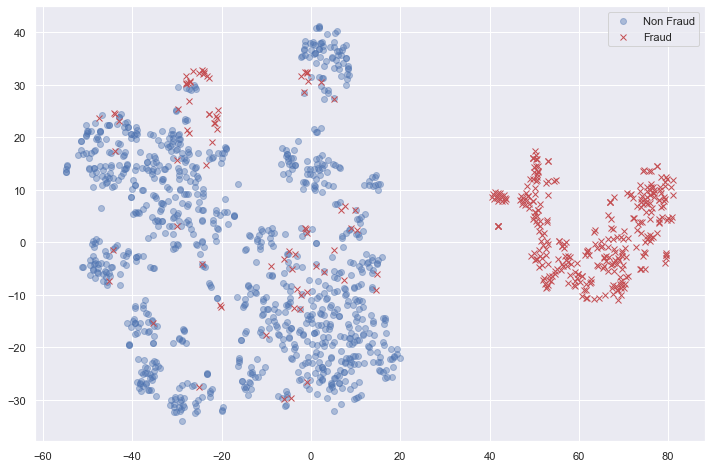

In [31]:
TSNE_plot(X_rep_test, y_rep_test)

**Observations**: The two target classes based on the latent variables are shown to be more or less linearly separable. There are still a handful of points that are still cluster together. Need to experiment more with the autoencoder architecture (e.g., changing the dimensions of hidden layers).

### Linear regression on latent variables

In [32]:
from sklearn.linear_model import LogisticRegression

In [33]:
clf = LogisticRegression(solver="lbfgs").fit(X_rep_train, y_rep_train)
y_pred = clf.predict(X_rep_test)

In [34]:
print ("")
print ("Classification Report: ")
print (classification_report(y_rep_test, y_pred))

print ("")
print ("Accuracy Score: ", accuracy_score(y_rep_test, y_pred))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97      1000
         1.0       1.00      0.84      0.91       394

   micro avg       0.95      0.95      0.95      1394
   macro avg       0.97      0.92      0.94      1394
weighted avg       0.96      0.95      0.95      1394


Accuracy Score:  0.9540889526542324


**Observations**: Achieved a higher overall accuracy score due to a higher $F$-score on classifying fraudulent predictions when latent variables are used to build the classifier.

### TODO: Try oversampling with SMOTE and denoising autoencoder

Methodology:
- SMOTE oversampling to balance original data set (use imblearn API)
- Train on denoised autoencoder
- Train denoised dataset on neural network.